## ASSET CLASSES

Use this utlity to update the correlations between asset classes in universe/asset-classes.csv

input files:
- asset-classes-2-etf.csv: mapping of asset classes to a representative ETF to use for calculating correlations
- asset-classes-in.csv: asset pairs for which to calculate correlations
- investment-options-in.csv: header for investment-options.csv

output files:
- symbols-cache/'symbol'.csv: timeseries for each symbol 
- symbols-timeseries.csv: compiled timeseries for symbols
- asset-classes.csv: asset class pairs with correlations
- investment-options.csv: you can use asset classes as an investment galaxy

Globals

In [1]:
# Set refresh_timeseries=True to download timeseries.  Otherwise /symbol-cache is used.
refresh_timeseries = True
throttle_limit=100
wait_time=30

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import brownbear as bb

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

In [4]:
# asset2etf dict provides a mapping from the asset name to a representative ETF.
asset2etf = pd.read_csv('asset-classes-2-etf.csv', skip_blank_lines=True, comment='#')
asset2etf = asset2etf.set_index(['Asset Class'])
asset2etf = asset2etf['ETF'].to_dict()
asset2etf

{'US Stocks': 'VTSMX',
 'Global Stocks': 'VXUS',
 'US Bonds': 'AGG',
 'Global Bonds': 'BNDX',
 'Cash Equivalents': 'BIL',
 'Real Estate': 'VNQ',
 'Commodities': 'DBC',
 'Currencies': 'UUP',
 'Managed Futures': 'CTA',
 'Balanced': 'AOM',
 'Risk-Free Asset': 'BIL',
 'US Stocks:Large Cap': 'SPY',
 'US Stocks:Mid Cap': 'MDY',
 'US Stocks:Small Cap': 'IWM',
 'US Stocks:Growth': 'QQQ',
 'US Stocks:Growth and Income': 'VOO',
 'US Stocks:Value': 'IWD',
 'US Stocks:Total Stock Market': 'VTI',
 'US Stocks:Materials': 'XLB',
 'US Stocks:Communication Services': 'XLC',
 'US Stocks:Energy': 'XLE',
 'US Stocks:Financials': 'XLF',
 'US Stocks:Industrials': 'XLI',
 'US Stocks:Technology': 'XLK',
 'US Stocks:Consumer Staples': 'XLP',
 'US Stocks:Real Estate': 'XLRE',
 'US Stocks:Utilities': 'XLU',
 'US Stocks:Healthcare': 'XLV',
 'US Stocks:Consumer Discretionary': 'XLY',
 'Global Stocks:Asia': 'VPL',
 'Global Stocks:Developed Markets': 'EFA',
 'Global Stocks:Emerging Markets': 'EEM',
 'Global Stocks:E

In [5]:
# Eliminate repeat symbols.
symbols = set(asset2etf.values())

In [6]:
# Get the timeseries for the symbols and compile into a single csv.
bb.fetch_timeseries(symbols, refresh=refresh_timeseries, throttle_limit=throttle_limit, wait_time=wait_time)
bb.compile_timeseries(symbols)

CTA EEM PALL VTSMX XLE BITW BIL GLD FXF FXB XLU AOA XLI BWX SPY DBB PFF VXUS VTI IEUR PPLT IBND FXC XLV VNQ AGG XLY IYR DBA XLC IWM AOM EBND CPER DBE LQD FXE AOR BWZ UNG UGA DBP FXY FXA CORN XLB CANE SLV AOK UUP EFA IWD XLP XLK JNK IEF MDY DBC XLF TIP USO QQQ XLRE JPST VPL TLT BNDX VOO 


In [7]:
# Read symbols timeseries into a dataframe.
df = pd.read_csv('symbols-timeseries.csv', skip_blank_lines=True, comment='#')
df.set_index("Date", inplace=True)
df

,CTA,EEM,PALL,VTSMX,XLE,BITW,BIL,GLD,FXF,FXB,...,XLF,TIP,USO,QQQ,XLRE,JPST,VPL,TLT,BNDX,VOO
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,34.12,120.03,56.72,43.60,NaN,78.72,121.33,94.11,113.94,...,21.26,89.81,78.80,148.76,24.66,41.78,50.86,103.58,44.93,207.79
2019-01-03,NaN,33.50,122.71,55.39,43.17,NaN,78.74,122.43,94.38,114.13,...,20.78,90.33,79.60,143.90,24.77,41.81,50.41,104.76,44.93,202.83
2019-01-04,NaN,34.59,125.70,57.31,44.64,NaN,78.75,121.44,94.48,115.08,...,21.47,90.15,81.44,150.05,25.02,41.81,52.10,103.54,44.89,209.52
2019-01-07,NaN,34.66,126.76,57.80,45.30,NaN,78.75,121.86,95.07,115.34,...,21.50,90.09,82.32,151.84,25.23,41.80,52.27,103.24,44.78,211.09
2019-01-08,NaN,34.79,128.27,58.41,45.65,NaN,78.75,121.53,94.92,114.90,...,21.51,90.16,84.00,153.21,25.67,41.80,52.45,102.97,44.75,213.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,28.25,43.53,86.74,131.93,82.97,54.92,91.40,309.07,108.20,129.12,...,48.17,109.67,67.76,472.41,40.78,50.45,75.49,89.12,49.29,506.42
2025-04-29,28.22,43.65,85.77,132.71,82.73,56.03,91.40,306.06,107.71,128.78,...,48.67,109.86,65.85,475.53,41.11,50.43,75.70,89.87,49.33,509.49
2025-04-30,28.06,43.76,86.00,132.83,80.50,54.54,91.41,303.77,107.54,128.07,...,48.76,109.99,63.56,475.47,41.30,50.46,75.53,89.14,49.45,509.74


np.float64(0.7802315235727505)

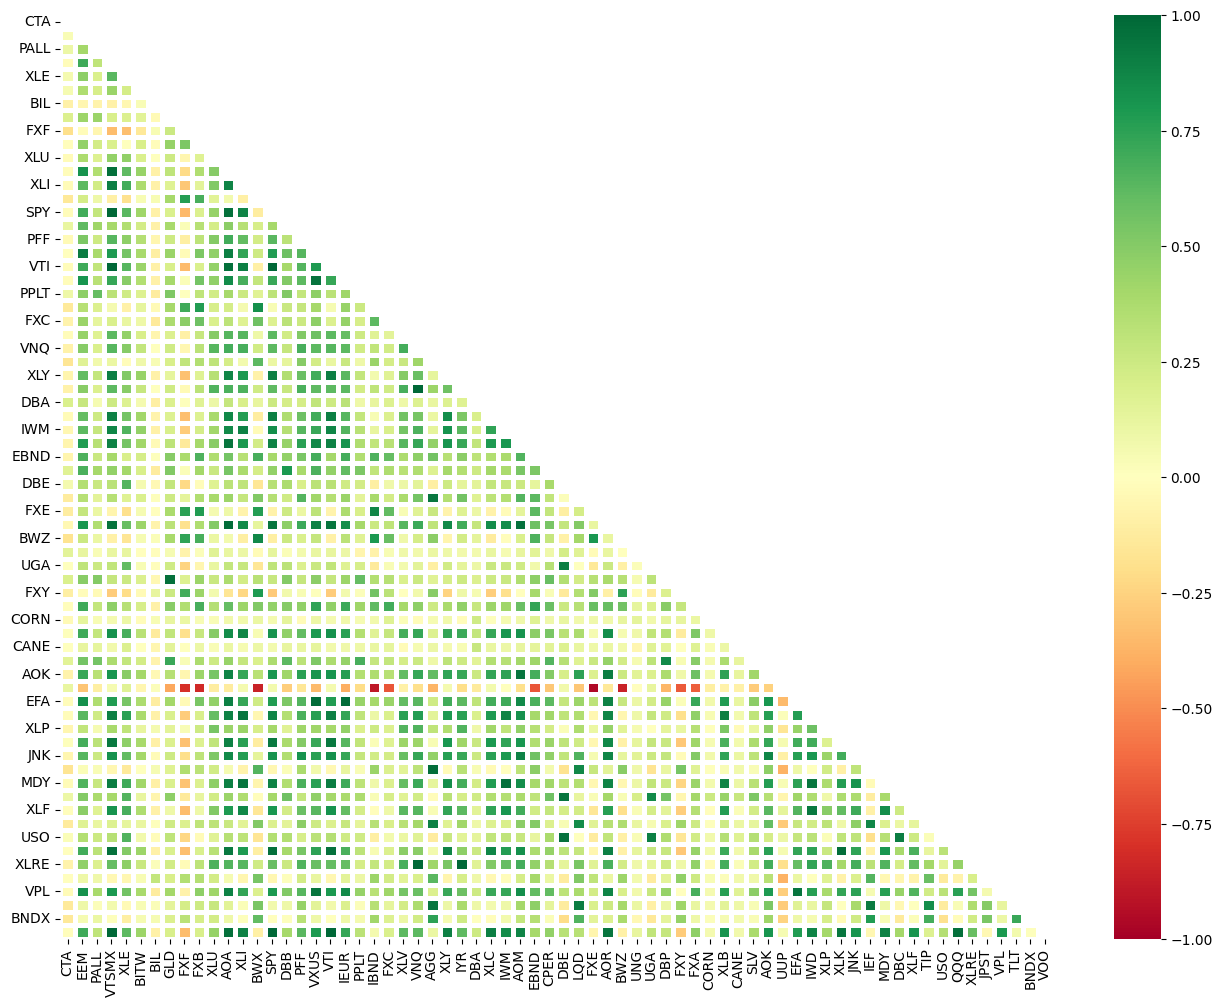

In [8]:
corr_map = bb.correlation_map(df, method='log', days=bb.TRADING_DAYS_PER_YEAR)
# Sample correlation value.
corr_map['SPY']['VXUS']

In [9]:
# Read asset-classes-in.csv
lines = []
with open('asset-classes-in.csv', 'r') as f:
    lines = [line.strip() for line in f]

In [10]:
# Calculate the pair correlations between the assets and write the resuls to a list.
out = []
for line in lines:
    # Copy empty and comment lines.
    if not line or line.startswith('#'):
        out.append(line)
        continue
    # Split line by comma delimiter; strip the fields.
    fields = line.split(',')
    fields = [field.strip() for field in fields]
    assetA = fields[0].strip('\"')
    assetB = fields[1].strip('\"')
    # copy same asset lines and header
    if assetA == assetB or assetA == 'Asset Class A':
        out.append(line)
        continue
    # Use asset2etf to get a representative ETF for the asset,
    # then calculate the correlation.  The ETF pair correlation is
    # a proxy for the correlation of an asset pair.
    etfA = asset2etf[assetA]
    etfB = asset2etf[assetB]
    corrAB = corr_map.loc[etfA, etfB]
    out.append(f'"{assetA}","{assetB}","{corrAB:0.2f}"')   

In [11]:
# Write out asset-classes.csv
with open('asset-classes.csv', 'w') as f:
    for line in out:
        f.write(line + '\n')

In [12]:
# Calculate Annual Returns.
annual_returns = bb.annualized_returns(df, timeperiod='daily', years=1)
annual_returns

CTA      4.54
EEM     12.41
PALL    -1.10
VTSMX   13.57
XLE     -9.46
         ... 
JPST     5.56
VPL      8.96
TLT      3.98
BNDX     6.32
VOO     14.36
Length: 68, dtype: float64

In [13]:
# Calculate 1 month, 3 months, 1 year, 3 year, and 5 year annualized returns.
annual_returns_1mo = bb.annualized_returns(df, timeperiod='daily', years=1/12)
annual_returns_3mo = bb.annualized_returns(df, timeperiod='daily', years=3/12)
annual_returns_1yr = bb.annualized_returns(df, timeperiod='daily', years=1)
annual_returns_3yr = bb.annualized_returns(df, timeperiod='daily', years=3)
annual_returns_5yr = bb.annualized_returns(df, timeperiod='daily', years=5)

In [14]:
# Calculate 20 day annualized volatility.
daily_returns = df.pct_change(fill_method=None)
years = bb.TRADING_DAYS_PER_MONTH / bb.TRADING_DAYS_PER_YEAR
vola = bb.annualized_standard_deviation(daily_returns, timeperiod='daily', years=years)

In [15]:
# Calculate 20 day annualized downside volatility.
ds_vola = bb.annualized_standard_deviation(daily_returns, timeperiod='daily', years=years, downside=True)

In [16]:
# Resample df on a monthly basis.
df.index = pd.to_datetime(df.index)
monthly = df.resample('ME').ffill()

In [17]:
# Calculate monthly returns.
monthly_returns = monthly.pct_change(fill_method=None)

In [18]:
# Calculate 1 year, 3 year, and 5 year annualized standard deviation.
std_dev_1yr = bb.annualized_standard_deviation(monthly_returns, timeperiod='monthly', years=1)
std_dev_3yr = bb.annualized_standard_deviation(monthly_returns, timeperiod='monthly', years=3)
std_dev_5yr = bb.annualized_standard_deviation(monthly_returns, timeperiod='monthly', years=5)

In [19]:
# Read investment-options-header.csv
lines = []
with open('investment-options-in.csv', 'r') as f:
    lines = [line.strip() for line in f]

In [20]:
# For each symbol, output the performance metrics 
out = lines.copy()

# This is still slow (2.53 s)
for key, value in asset2etf.items():

    symbol = value
    asset_class = key

    ret_1mo = annual_returns_1mo[symbol]
    ret_3mo = annual_returns_3mo[symbol]
    ret_1yr = annual_returns_1yr[symbol]
    ret_3yr = annual_returns_3yr[symbol]
    ret_5yr = annual_returns_5yr[symbol]

    if np.isnan(ret_3yr): ret_3yr = ret_1yr
    if np.isnan(ret_5yr): ret_5yr = ret_3yr
    
    _vola = vola[symbol]*100
    _ds_vola = ds_vola[symbol]*100
    sd_1yr = std_dev_1yr[symbol]*100
    sd_3yr = std_dev_3yr[symbol]*100
    sd_5yr = std_dev_5yr[symbol]*100

    out.append((
        '"{}","{}","{}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}",'
        '"{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}"'
    ).format(
        asset_class, asset_class, asset_class, ret_1mo, ret_3mo, ret_1yr, ret_3yr,
        ret_5yr, _vola, _ds_vola, sd_1yr, sd_3yr, sd_5yr
    ))

In [21]:
# Write out asset-classes.csv
with open('investment-options.csv', 'w') as f:
    for line in out:
        f.write(line + '\n')